In [1]:
import numpy as np
import pandas as pd
import csv
import re

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm

In [2]:
def preprocess(text):
    text = text.lower()
    text = ''.join(re.findall(r'[ а-я]', text))
    return text.split()

In [3]:
tweets = []
    
try:
    reader = csv.reader(open('twitter.csv', 'r'), delimiter=';')
    for line in reader:
        line = preprocess(line[3])
        if len(line) > 10:
            tweets.append(line)
except: # some bug with encoding in the end of file
    pass

In [4]:
bibl = []

with open('bibl.txt', 'r', encoding="windows-1251") as file:
    for line in file:
        line = preprocess(line)
        if len(line) > 10:
            bibl.append(line)

In [5]:
tolstoy = []

with open('tolst.txt', 'r', encoding="windows-1251") as file:
    for line in file:
        line = preprocess(line)
        if len(line) > 10:
            tolstoy.append(line)

In [6]:
class Vocab:
    def __init__(self, corpora, tokenizer, max_len=20, vocab_size=5000):
        self.tokenizer = tokenizer
        self.max_len = max_len
        
        counts = {}
        
        for sentence in corpora:
            for token in sentence:
                counts[token] = counts.get(token, 0) + 1
        
        l = sorted(counts.items(), key=lambda x: -x[1])[:vocab_size-2]
        
        print('least used token:', l[-1])
        print('vocab size:', len(l), '(+2)')
        
        self.t2i = {"<pad>" : 0, "<unk>" : 1}
        self.i2t = {0 : "<pad>", 1 : "<unk>"}
              
        for token, _ in l:
            self.i2t[len(self.i2t)] = token
            self.t2i[token] = len(self.t2i)
    
    def tokenize(self, sentence, pad=True):
        if pad:
            sentence = sentence[:self.max_len]
            while len(sentence) < self.max_len:
                sentence.append('<pad>')
        
        indices = []
        for token in sentence:
            if token in self.t2i:
                indices.append(self.t2i[token])
            else:
                indices.append(1)
        
        return indices

In [32]:
# me: mom can we have oversampling?
# mom: but we have oversampling at home
# oversampling at home:
dataset_a = tweets+tweets
dataset_b = tolstoy+tolstoy+tolstoy+tolstoy
dataset_c = bibl

print(len(dataset_a))
print(len(dataset_b))
print(len(dataset_c))

vocab = Vocab(dataset_a + dataset_b + dataset_c, preprocess)

39506
34480
30733
least used token: ('очнулся', 54)
vocab size: 4998 (+2)


In [33]:
class StyleDataset(Dataset):
    def __init__(self, corpora, vocab):
        self.vocab = vocab
        self.samples = []
        self.labels = []
        
        for i, dataset in enumerate(corpora):
            self.samples += dataset
            self.labels += [i] * len(dataset)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        X = self.vocab.tokenize(self.samples[idx])
        y = [self.labels[idx]] * len(X)
        return torch.LongTensor(X), torch.LongTensor(y)

In [34]:
dataset = StyleDataset([dataset_a, dataset_b, dataset_c], vocab)

# todo: this should be done before oversampling
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset)-512, 512])

train = DataLoader(train_dataset, batch_size=64, shuffle=True)
test = DataLoader(test_dataset, batch_size=64)

dataset[5]

(tensor([  22,   64,   60,    1,   66,  240, 1844,    4,   76,    4,    1,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [35]:
def fetch_embeddings(embeddings, vocab, embedding_dim=300):
    weights = torch.randn(len(vocab.t2i), embedding_dim) / 10
    
    print('reading file', embeddings)
    print('this may take a while...')
    
    with open(embeddings) as file:
        for line in file:
            data = line.split()
            if len(data) == embedding_dim + 1:
                token = data[0]
                vector = torch.Tensor([float(x) for x in data[1:]])
                if token in vocab.t2i:
                    weights[vocab.t2i[token]] = vector
    
    return weights


class StyleClassifier(nn.Module):
    def __init__(
        self,
        embeddings,
        embedding_dim=300,
        num_classes=3,
        hidden_dim=50,
        num_layers=1,
        rnn_dropout=0,
        bidirectional=False):
        
        super().__init__()
        
        self.embed = nn.Embedding.from_pretrained(embeddings)
        
        self.rnn = nn.GRU(
            embedding_dim,
            hidden_dim, 
            num_layers=num_layers, 
            bidirectional=bidirectional, 
            dropout=rnn_dropout,
            batch_first=True
        )
        
        self.head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes),
            nn.LogSoftmax(dim=2)
        )
        
    def forward(self, X):
        X = self.embed(X)
        X, _ = self.rnn(X)
        X = self.head(X)
        return X

In [36]:
!touch empty.vec

In [37]:
embeddings = fetch_embeddings('wiki.ru.vec', vocab, embedding_dim=300)
model = StyleClassifier(embeddings)

reading file wiki.ru.vec
this may take a while...


In [38]:
test_batch = dataset[0][0].view(1, -1)
model(test_batch).exp()

tensor([[[0.3021, 0.4042, 0.2937],
         [0.3086, 0.3449, 0.3464],
         [0.3351, 0.3389, 0.3260],
         [0.3465, 0.3635, 0.2900],
         [0.3233, 0.3535, 0.3233],
         [0.2828, 0.3858, 0.3314],
         [0.3405, 0.2965, 0.3630],
         [0.3860, 0.3346, 0.2795],
         [0.3371, 0.3375, 0.3254],
         [0.3562, 0.3350, 0.3088],
         [0.3265, 0.3963, 0.2772],
         [0.3285, 0.4285, 0.2430],
         [0.3427, 0.3934, 0.2639],
         [0.3121, 0.4145, 0.2734],
         [0.3126, 0.3830, 0.3043],
         [0.3269, 0.3821, 0.2910],
         [0.3308, 0.3742, 0.2950],
         [0.3213, 0.3821, 0.2967],
         [0.3269, 0.3494, 0.3238],
         [0.3255, 0.3828, 0.2918]]], grad_fn=<ExpBackward>)

In [39]:
lr = 5e-2
num_epochs = 10
device = torch.device('cpu')

#model = StyleClassifier(len(vocab.i2t), 'fasttext.vec')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.NLLLoss()

In [40]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    
    for X, y in tqdm(train):
        X.to(device)
        y.to(device)
        
        optimizer.zero_grad()
        
        preds = model(X)
        
        loss = criterion(preds.view(-1, 3), y.view(-1))
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
    test_loss = 0
    for X, y in tqdm(test):
        X.to(device)
        y.to(device)
        
        preds = model(X)
        loss = criterion(preds.view(-1, 3), y.view(-1))
        
        test_loss += loss.item()
    
    test_losses.append(test_loss)
    print('test loss:', test_loss)

  0%|          | 3/1629 [00:00<00:55, 29.09it/s]

test loss: 4.373262286186218


  0%|          | 5/1629 [00:00<00:38, 42.69it/s]

test loss: 4.33011394739151


  0%|          | 3/1629 [00:00<00:55, 29.20it/s]

test loss: 5.043442130088806


  0%|          | 4/1629 [00:00<00:46, 34.76it/s]

test loss: 5.075984477996826


  0%|          | 4/1629 [00:00<00:42, 38.22it/s]

test loss: 5.506213545799255


  0%|          | 4/1629 [00:00<00:49, 33.03it/s]

test loss: 5.543834090232849


  0%|          | 5/1629 [00:00<00:37, 42.74it/s]

test loss: 5.107075333595276


  0%|          | 4/1629 [00:00<00:46, 34.88it/s]

test loss: 5.090076506137848


  0%|          | 4/1629 [00:00<00:46, 34.81it/s]

test loss: 4.906137466430664


100%|██████████| 8/8 [00:00<00:00, 90.61it/s]

test loss: 5.1415969133377075


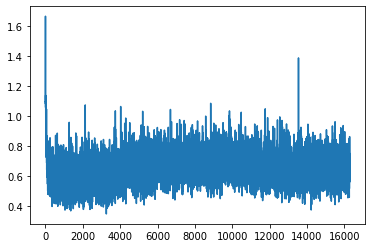

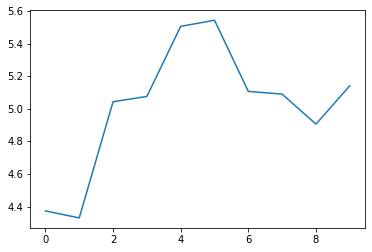

In [41]:
plt.plot(train_losses)
plt.show()

plt.plot(test_losses)
plt.show()

In [42]:
from IPython.core.display import display, HTML

def print_colored(sequence, intensities, delimeter=' '):
    html = delimeter.join([
        # https://en.wikipedia.org/wiki/Subtractive_color
        f'<span style="background: rgb({255*(1-x[1]-x[2])}, {255*(1-x[0]-x[2])}, {255*(1-x[0]-x[1])})">{c}</span>'
        for c, x in zip(sequence, intensities) 
    ])
    display(HTML(html))

In [43]:
samples = [
    'Сап б, есть одна тян. Двачую однаапррвавапвпв анон',
    'князь болконский с удивлением увидел',
    'засмеялся проиграл тред не нашел создал',
    'хахаха ну ты даешь',
    'Сап двач, есть однаапррвавапвпв хэштег тян, она как будто со вниманием слушала рассказ князя Василья',
    ' '.join(dataset_a[111]), # Твиттер, должен быть красным
    ' '.join(dataset_b[111]), # bible, должна быть зелёной
    ' '.join(dataset_c[333]), # Tolstoy, должен быть синим
    ' '.join(dataset_a[6] + dataset_b[6] + dataset_c[6])
]

model = model.cpu()

t = 1 # температура, для лучшей визуализации

for sample in samples:
    sentence = preprocess(sample)
    X = torch.LongTensor(vocab.tokenize(sample, pad=False)).view(-1, 1)
    scores = model(X).view(-1, 3).mul(t).softmax(dim=1)
    maxes, _ = torch.max(scores, dim=1)
    scores -= ((1-maxes)/2).view(-1, 1) # так будет ровно один "полный" цвет
    #print(scores)
    print_colored(sentence, scores)